In [34]:
'''
Unsupervised k-means clustering on plain text file versions of EEBO-TCP texts. 
The plain text files are generated by running stageOne.py 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file also made using stageOne.py 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The pca function is adapted from Ask Python: 
    https://www.askpython.com/python/examples/plot-k-means-clusters-python 
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The optimalK function is adapted from Kajal Yadav's Medium article: 
    https://towardsdatascience.com/text-clustering-using-k-means-ec19768aae48
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# import our own utility functions 
from functions import remove_stopwords,getTexts,keywords


def vectorize(strings,ids):
    # min document freq set to 2 to exclude words that only occur in a single text (limit num of features)
    # comment below is from EarlyPrint 
    # sublinear term frequency scaling takes the log of
    # term frequencies and can help to de-emphasize function words like pronouns and articles. 
    tfidf = TfidfVectorizer(min_df=2, sublinear_tf=True)

    # Commented out portion below is for removing stopwords 
    processed = remove_stopwords(strings)
    newStrings = []
    for doc in processed:
        str = ' '.join(doc)
        newStrings.append(str)
    results = tfidf.fit_transform(newStrings)
    
    # results = tfidf.fit_transform(strings) #comment this out if you choose to remove stopwords 
    return pd.DataFrame(results.toarray(), index=ids, columns=tfidf.get_feature_names_out()) # Convert information back to a DataFrame

def pca(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python 
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df)
    label = kmeans.fit_predict(pca_results)
    u_labels = np.unique(label)
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i)
    plt.legend()
    plt.show()

def cluster(df,ids,num):
    # Create a KMeans instance that will look for a specified number of clusters
    # Random_state parameter helps for reproducibility. 42 is a common choice 
    model = KMeans(n_clusters=num, random_state=42) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
        
    for k,v in kmeans_groups.items():
        print(k, ': ',v)

    return kmeans_groups,model

def topTerms(model,num):
    ''' 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/
    '''
    print("Top terms per cluster:")
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = df.columns.values
    for i in range(num):
        top = []
        print("Cluster %d:" % i),
        for ind in centroids[i, :10]:
            top.append(terms[ind])
        print(str(top))

def optimalK(model):
    '''
    Finds scores for each model (different values of k)
    Plots SSEs on a line chart to identify the elbow of the line, i.e., the optimal value of k
    '''
    num_clusters = range(1, 10)  # Range of possible clusters that can be generated
    kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters] # Getting no. of clusters 

    score = [kmeans[i].fit(model).inertia_ for i in range(len(kmeans))] # Getting score corresponding to each cluster.
    
    plt.plot(num_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow Method')
    plt.show()

In [37]:
folder = '/srv/data/newEPTuningCleaner'
csvFile = '/srv/data/metadata/tuning/EPtuning.csv'

# folder = '/srv/data/VirginiaEPTextClean'
# csvFile = '/srv/data/metadata/tuning/virginia.csv'
info = getTexts(folder)
df = vectorize(info[0],info[1])
# optimalK(df)

0 :  ['A01932', 'A04813', 'A07886', 'A12458', 'A12460', 'A12466', 'A21108', 'A51598', 'A57391', 'B00963']
1 :  ['A02495', 'A03149', 'A10821', 'A31106', 'A41427', 'A68617', 'A71305', 'A71306', 'A71307']
3 :  ['A13290', 'A69149', 'A77422', 'B00052']
2 :  ['A37936', 'A83297']
4 :  ['A66847']


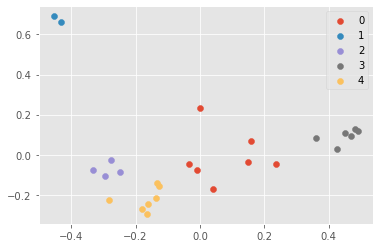

Top terms per cluster:
Cluster 0:
['aac', 'aaron']
Cluster 1:
['aaron', 'aac']
Cluster 2:
['aaron', 'aac']
Cluster 3:
['aac', 'aaron']
Cluster 4:
['aac', 'aaron']


In [38]:
groups,model = cluster(df,info[1],5)
pca(model,df)
topTerms(model,5)

In [ ]:
words = keywords(csvFile)
for k,v in groups.items():
    print(f'Group {k}')
    keyterms = []
    for name in v: 
        if '_' not in name:
            keyterms.extend(words[name][0])
    print(Counter(keyterms))